In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent

from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class ELBO(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: Tensor) -> Tensor:
        q = self.encoder(x)
        z = q.rsample()
        

        return self.decoder(z).log_prob(x) + self.prior().log_prob(z) - q.log_prob(z)

In [32]:
class GaussianModel(zuko.flows.LazyDistribution):
    def __init__(self, features: int, context: int):
        super().__init__()

        self.hyper = nn.Sequential(
            nn.Linear(context, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * features),
        )

    def forward(self, c: Tensor) -> Distribution:
        phi = self.hyper(c)
        mu, log_sigma = phi.chunk(2, dim=-1)
        
        
        return Independent(Normal(mu, log_sigma.exp()), 1)


In [20]:
# Generate moons dataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=0.0)
# scale data 

X = torch.Tensor(X)




Text(0.5, 1.0, '$P(\\mathbf{x})$')

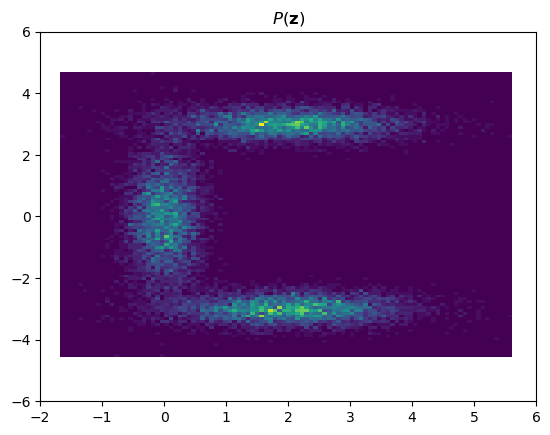

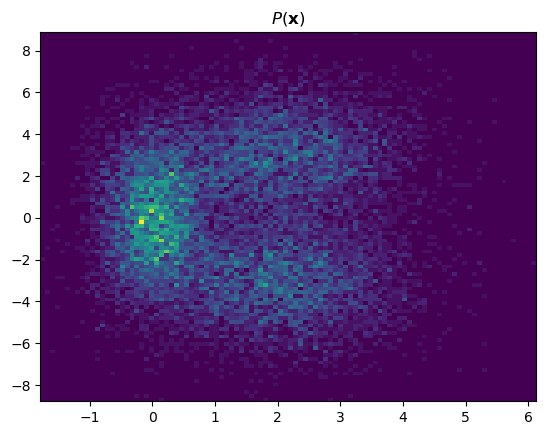

In [6]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((10000,)).reshape((-1, 2))

import matplotlib.pyplot as plt
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)

fig, ax = plt.subplots()
plt.hist2d(Z_train[:, 0].numpy(), Z_train[:, 1].numpy(), bins=100) #, ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{z})$')

S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]

fig, ax = plt.subplots()
plt.hist2d(X_train[:, 0].numpy(), X_train[:, 1].numpy(), bins=100) #, ax=ax

ax.set_title(r'$P(\mathbf{x})$')

In [41]:
trainloader = data.DataLoader(X, batch_size=256, shuffle=True)

In [42]:
encoder = GaussianModel(256, 2)
decoder = zuko.flows.MAF(
    features=2,
    context=256,
    transforms=4,
    hidden_features=(256, 256),
)

prior = zuko.flows.MAF(
    features=256,
    transforms=4,
    hidden_features=(256, 256),
)

elbo = ELBO(encoder, decoder, prior)
optimizer = torch.optim.Adam(elbo.parameters(), lr=1e-4)

for epoch in (bar := tqdm(range(1000))):
    losses = []

    for x in trainloader:
        # x = x.round().flatten(-3)

        loss = -elbo(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    bar.set_postfix(loss=losses.mean().item())

100%|██████████| 1000/1000 [1:39:39<00:00,  5.98s/it, loss=-.526]  


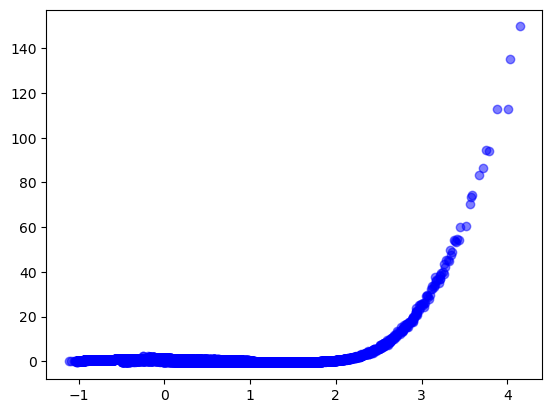

In [44]:
z = prior().sample((10000,))
x = decoder(z).rsample()
plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), c="b", alpha=0.5)

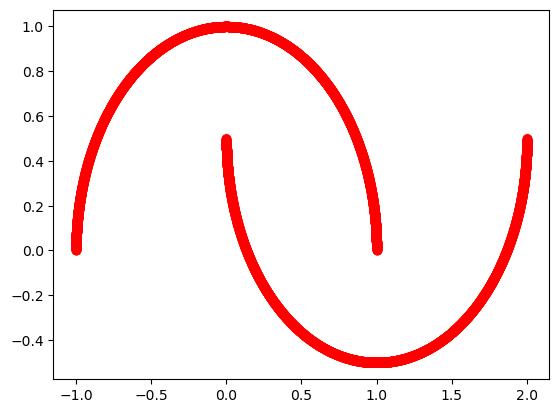

In [45]:
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c="r", alpha=0.5)

In [17]:
X

tensor([[ 0.5696, -0.2773],
        [-1.5945,  0.4487],
        [-0.3427, -0.7168],
        ...,
        [-1.1560,  1.2454],
        [ 0.4874,  0.2761],
        [-0.9239,  1.4252]])